In [1]:
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pickle

In [2]:
seed = 0
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(seed)

In [3]:
carpetaDeceptive = Path("Data/Transcription/chinese_bert_persentence/Deceptive")
carpetaTruthful = Path("Data/Transcription/chinese_bert_persentence/Truthful")

transcription_d = []
transcription_t = []

labels_text = []


for archivo in sorted(carpetaDeceptive.iterdir()):
    with archivo.open("r", encoding="utf-8") as f:
        df = pd.read_csv(f, sep=" ", header=None, usecols=range(128))  
        transcription_d.append(df.values)
labels_text = [0 for i in range(len(transcription_d))]

for archivo in sorted(carpetaTruthful.iterdir()):
    with archivo.open("r", encoding="utf-8") as f:
        df = pd.read_csv(f, sep=" ", header=None, usecols=range(128))  
        transcription_t.append(df.values)
labels_text += [1 for i in range(len(transcription_t))]

transcription = transcription_d + transcription_t
labels_text = np.array(labels_text)
#etiquetas = etiquetas.reshape(-1, 1)

In [4]:
data_idx = np.load("holdout_indices.npz")
dev_idx = data_idx["dev"]
test_idx = data_idx["test"]

print(len(dev_idx))
print(len(test_idx))


262
47


In [5]:
with open('fold_indices.pkl', 'rb') as f:
    folds = pickle.load(f)



fold_indices_validation = []
for fold in folds:
    fold_indices_validation.append(fold[1])

fold_indices_validation = np.concatenate(fold_indices_validation)

In [6]:
features_text = np.array([np.mean(clip,axis=0) for clip in transcription])
print(features_text.shape)
print(labels_text.shape)
# DEV
dev_features_text = features_text[dev_idx]
dev_labels_text = labels_text[dev_idx]

# TEST
test_features_text = features_text[test_idx]
test_labels_text = labels_text[test_idx]

dev_features_text = dev_features_text[fold_indices_validation]
dev_labels_text = dev_labels_text[fold_indices_validation]



(309, 128)
(309,)


In [7]:
dev_data_video = np.load("final_features/dev/video_features_and_labels.npz")
test_data_video = np.load("final_features/test/video_features_and_labels.npz")

# DEV
dev_features_video = dev_data_video["features"]
dev_labels_video = dev_data_video["labels"]

# TEST
test_features_video = test_data_video["features"]
test_labels_video = test_data_video["labels"]

print(dev_features_video.shape)
print(dev_labels_video.shape)
print(test_features_video.shape)
print(test_labels_video.shape)




(262, 128)
(262,)
(47, 128)
(47,)


In [8]:
dev_data_audio = np.load("final_features/dev/audio_features_and_labels.npz")
test_data_audio = np.load("final_features/test/audio_features_and_labels.npz")

# DEV
dev_features_audio = dev_data_audio["features"]
dev_labels_audio = dev_data_audio["labels"]

# TEST
test_features_audio = test_data_audio["features"]
test_labels_audio = test_data_audio["labels"]


In [9]:
print(np.array_equal(dev_labels_video, dev_labels_audio))

True


In [10]:
print(np.array_equal(dev_labels_text,  dev_labels_video) and np.array_equal(dev_labels_video, dev_labels_audio))

True


In [11]:
print(dev_labels_text[0:50])
print(dev_labels_video[0:50])
print(dev_labels_audio[0:50])

[1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 0]
[1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 0]
[1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 0]


In [12]:
# Normalizar todo

dev_features_text = normalize(dev_features_text, norm='l2', axis=1, copy=False)
dev_features_video = normalize(dev_features_video, norm='l2', axis=1, copy=False)
dev_features_audio = normalize(dev_features_audio, norm='l2', axis=1, copy=False)


In [13]:
class MultimodalDataset(Dataset):
    def __init__(self, text_features, video_features, audio_features, labels):
        self.text = torch.tensor(text_features, dtype=torch.float32)
        self.video = torch.tensor(video_features, dtype=torch.float32)
        self.audio = torch.tensor(audio_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.text[idx], self.video[idx], self.audio[idx], self.labels[idx]

In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)

def evaluar_modelo(model, test_loader, path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Evalúa el modelo en test_loader cargando pesos desde 'path' y calcula varias métricas.

    Parámetros:
    - model: instancia de torch.nn.Module
    - test_loader: DataLoader con tu dataset de prueba
    - path: ruta al .pth con los pesos
    - device: dispositivo ('cpu' o 'cuda')
    - threshold: umbral para convertir probabilidades en etiquetas binaras
    """
    
    model.load_state_dict(torch.load(path, weights_only=True))
    model.to(device)
    model.eval()

    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_text, x_video, x_audio, y_batch in test_loader:
            x_text   = x_text.to(device)
            x_video  = x_video.to(device)
            x_audio  = x_audio.to(device)
            y_batch  = y_batch.to(device)

            logits = model(x_text, x_video, x_audio)
            preds = logits.argmax(dim=1) 


            all_preds.append(preds.cpu())
            all_labels.append(y_batch.view(-1).cpu().long())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, zero_division=0)
    rec    = recall_score(all_labels, all_preds, zero_division=0)
    f1     = f1_score(all_labels, all_preds, zero_division=0)
    confm  = confusion_matrix(all_labels, all_preds)
   
    print(f"Total ejemplos en test: {len(all_labels)}")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"F1-score:      {f1:.4f}")
    print("Matriz de confusión:")
    print(confm)


In [15]:
class ResBlock(nn.Module):
    def __init__(self, dim, drop_prob=0.2):
        super(ResBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.Dropout(drop_prob),
        )

    def forward(self, x):
        return x + self.net(x)

In [16]:
class SoftmaxGatedFusion(nn.Module):
    def __init__(self, text_dim=128, video_dim=128, audio_dim=20, proj_hidden_dim=128, hidden_dim=128):
        super().__init__()
        self.text = nn.Sequential(
            nn.Linear(text_dim,  proj_hidden_dim),
            nn.LayerNorm(proj_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),    
            ResBlock(proj_hidden_dim),  
            
        )
        self.video = nn.Sequential(
            nn.Linear(video_dim, proj_hidden_dim),
            nn.LayerNorm(proj_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            ResBlock(proj_hidden_dim), 
            
        )
        
        self.audio = nn.Sequential(
            nn.Linear(audio_dim,  proj_hidden_dim),
            nn.LayerNorm(proj_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            ResBlock(proj_hidden_dim), 
            
        )
        
        # MLP de gating que sale en 3 logits
        self.gate_mlp   = nn.Sequential(
            nn.Linear(proj_hidden_dim*3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 3)
        )
        
        # Clasificador final
        self.classifier = nn.Sequential(
        nn.Linear(proj_hidden_dim, hidden_dim//2),
        nn.ReLU(),
        nn.Dropout(0.5),         
        nn.Linear(hidden_dim//2, 2)          
        )


    def forward(self, x_t, x_v, x_a):
        t = self.text(x_t)
        v = self.video(x_v)
        a = self.audio(x_a)
        # calcular pesos
        concat = torch.cat([t, v, a], dim=1)           # (B, 3H)
        w_logits = self.gate_mlp(concat)               # (B, 3)
        weights  = torch.softmax(w_logits, dim=1)      # (B, 3) sum=1
        # fusionar ponderando cada modalidad
        fused = (weights[:,0:1]*t +
                 weights[:,1:2]*v +
                 weights[:,2:3]*a)
        return self.classifier(fused)

In [17]:

model = SoftmaxGatedFusion()
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parámetros entrenables: {n_params:,}")

Número de parámetros entrenables: 195,141


In [18]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else device

print(device)

cuda


In [19]:
# Dataset 
train_dataset = MultimodalDataset(dev_features_text, dev_features_video, dev_features_audio, dev_labels_text)

# Dataset apartado para el test, datos completamente nuevos
test_dataset = MultimodalDataset(test_features_text, test_features_video, test_features_audio, test_labels_text)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)



--- Fold 1 ---
Epoch 001 | Tr Loss: 0.7337 Acc: 0.4785 | Val Loss: 0.6898 Acc: 0.6226
 ↳ Mejores pesos guardados (Val Acc: 0.6226)
Epoch 002 | Tr Loss: 0.7479 Acc: 0.4737 | Val Loss: 0.6734 Acc: 0.6226
 ↳ Sin mejora 1/30
Epoch 003 | Tr Loss: 0.7061 Acc: 0.5263 | Val Loss: 0.7005 Acc: 0.3774
 ↳ Sin mejora 2/30
Epoch 004 | Tr Loss: 0.7096 Acc: 0.5263 | Val Loss: 0.6739 Acc: 0.6226
 ↳ Sin mejora 3/30
Epoch 005 | Tr Loss: 0.6908 Acc: 0.5407 | Val Loss: 0.6953 Acc: 0.4906
 ↳ Sin mejora 4/30
Epoch 006 | Tr Loss: 0.7410 Acc: 0.4641 | Val Loss: 0.6873 Acc: 0.5849
 ↳ Sin mejora 5/30
Epoch 007 | Tr Loss: 0.7028 Acc: 0.5072 | Val Loss: 0.7107 Acc: 0.3774
 ↳ Sin mejora 6/30
Epoch 008 | Tr Loss: 0.6950 Acc: 0.5072 | Val Loss: 0.6903 Acc: 0.5283
 ↳ Sin mejora 7/30
Epoch 009 | Tr Loss: 0.6957 Acc: 0.5407 | Val Loss: 0.6795 Acc: 0.6226
 ↳ Sin mejora 8/30
Epoch 010 | Tr Loss: 0.6977 Acc: 0.5502 | Val Loss: 0.6820 Acc: 0.6226
 ↳ Sin mejora 9/30
Epoch 011 | Tr Loss: 0.7031 Acc: 0.5167 | Val Loss: 0.6899

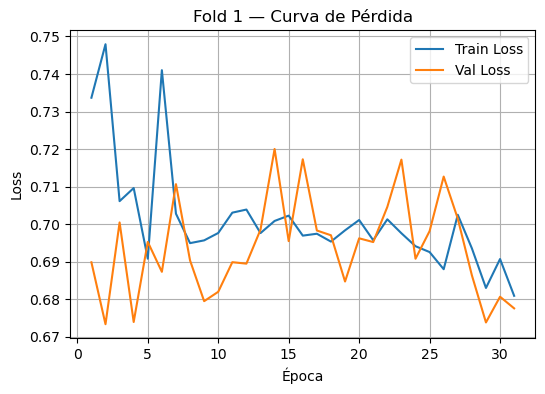

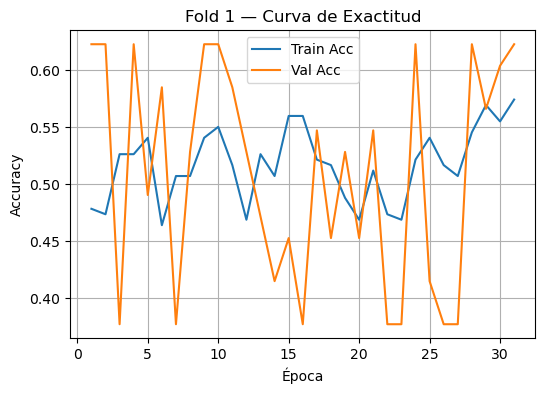


--- Fold 2 ---
Epoch 001 | Tr Loss: 0.7480 Acc: 0.4019 | Val Loss: 0.6901 Acc: 0.5283
 ↳ Mejores pesos guardados (Val Acc: 0.5283)
Epoch 002 | Tr Loss: 0.7018 Acc: 0.4928 | Val Loss: 0.6860 Acc: 0.5283
 ↳ Sin mejora 1/30
Epoch 003 | Tr Loss: 0.7080 Acc: 0.5024 | Val Loss: 0.6931 Acc: 0.4906
 ↳ Sin mejora 2/30
Epoch 004 | Tr Loss: 0.7206 Acc: 0.4354 | Val Loss: 0.6922 Acc: 0.5472
 ↳ Mejores pesos guardados (Val Acc: 0.5472)
Epoch 005 | Tr Loss: 0.6891 Acc: 0.5215 | Val Loss: 0.6983 Acc: 0.5283
 ↳ Sin mejora 1/30
Epoch 006 | Tr Loss: 0.6969 Acc: 0.4976 | Val Loss: 0.7168 Acc: 0.5283
 ↳ Sin mejora 2/30
Epoch 007 | Tr Loss: 0.7148 Acc: 0.5024 | Val Loss: 0.6960 Acc: 0.5283
 ↳ Sin mejora 3/30
Epoch 008 | Tr Loss: 0.6957 Acc: 0.5311 | Val Loss: 0.6926 Acc: 0.5283
 ↳ Sin mejora 4/30
Epoch 009 | Tr Loss: 0.7012 Acc: 0.5311 | Val Loss: 0.7016 Acc: 0.4717
 ↳ Sin mejora 5/30
Epoch 010 | Tr Loss: 0.7095 Acc: 0.4880 | Val Loss: 0.6913 Acc: 0.5283
 ↳ Sin mejora 6/30
Epoch 011 | Tr Loss: 0.7004 Acc:

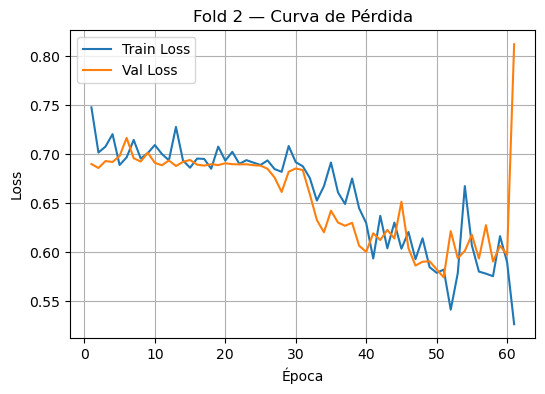

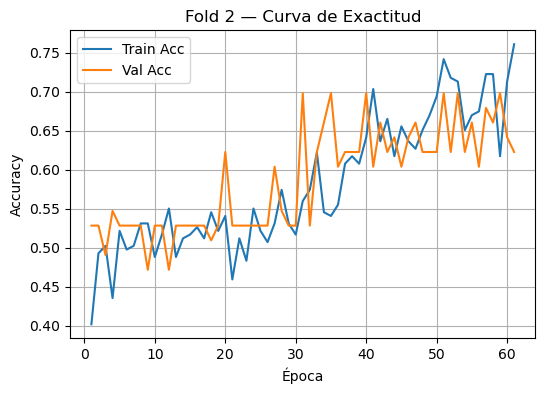


--- Fold 3 ---
Epoch 001 | Tr Loss: 0.7331 Acc: 0.4762 | Val Loss: 0.7093 Acc: 0.5000
 ↳ Mejores pesos guardados (Val Acc: 0.5000)
Epoch 002 | Tr Loss: 0.7198 Acc: 0.5143 | Val Loss: 0.7004 Acc: 0.5192
 ↳ Mejores pesos guardados (Val Acc: 0.5192)
Epoch 003 | Tr Loss: 0.7305 Acc: 0.5333 | Val Loss: 0.7228 Acc: 0.4808
 ↳ Sin mejora 1/30
Epoch 004 | Tr Loss: 0.7157 Acc: 0.5333 | Val Loss: 0.7030 Acc: 0.4423
 ↳ Sin mejora 2/30
Epoch 005 | Tr Loss: 0.7083 Acc: 0.5000 | Val Loss: 0.7027 Acc: 0.4231
 ↳ Sin mejora 3/30
Epoch 006 | Tr Loss: 0.7009 Acc: 0.4952 | Val Loss: 0.6963 Acc: 0.5192
 ↳ Sin mejora 4/30
Epoch 007 | Tr Loss: 0.7069 Acc: 0.4524 | Val Loss: 0.6921 Acc: 0.5000
 ↳ Sin mejora 5/30
Epoch 008 | Tr Loss: 0.6939 Acc: 0.5095 | Val Loss: 0.6932 Acc: 0.5192
 ↳ Sin mejora 6/30
Epoch 009 | Tr Loss: 0.6962 Acc: 0.5143 | Val Loss: 0.6969 Acc: 0.5192
 ↳ Sin mejora 7/30
Epoch 010 | Tr Loss: 0.6983 Acc: 0.5095 | Val Loss: 0.6961 Acc: 0.5192
 ↳ Sin mejora 8/30
Epoch 011 | Tr Loss: 0.6958 Acc:

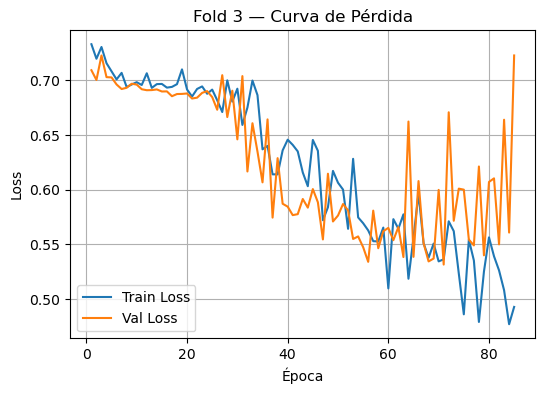

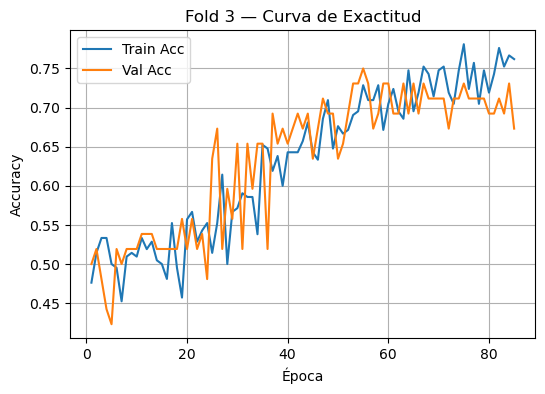


--- Fold 4 ---
Epoch 001 | Tr Loss: 0.7376 Acc: 0.5190 | Val Loss: 0.7143 Acc: 0.4423
 ↳ Mejores pesos guardados (Val Acc: 0.4423)
Epoch 002 | Tr Loss: 0.7276 Acc: 0.5286 | Val Loss: 0.7395 Acc: 0.4423
 ↳ Sin mejora 1/30
Epoch 003 | Tr Loss: 0.7383 Acc: 0.4476 | Val Loss: 0.7724 Acc: 0.4423
 ↳ Sin mejora 2/30
Epoch 004 | Tr Loss: 0.7137 Acc: 0.5476 | Val Loss: 0.7214 Acc: 0.4423
 ↳ Sin mejora 3/30
Epoch 005 | Tr Loss: 0.7154 Acc: 0.4619 | Val Loss: 0.7199 Acc: 0.4423
 ↳ Sin mejora 4/30
Epoch 006 | Tr Loss: 0.7134 Acc: 0.5048 | Val Loss: 0.7005 Acc: 0.4423
 ↳ Sin mejora 5/30
Epoch 007 | Tr Loss: 0.6893 Acc: 0.5381 | Val Loss: 0.7069 Acc: 0.4423
 ↳ Sin mejora 6/30
Epoch 008 | Tr Loss: 0.7016 Acc: 0.5238 | Val Loss: 0.7113 Acc: 0.4423
 ↳ Sin mejora 7/30
Epoch 009 | Tr Loss: 0.7074 Acc: 0.5381 | Val Loss: 0.7075 Acc: 0.4423
 ↳ Sin mejora 8/30
Epoch 010 | Tr Loss: 0.7069 Acc: 0.5333 | Val Loss: 0.7006 Acc: 0.4423
 ↳ Sin mejora 9/30
Epoch 011 | Tr Loss: 0.6957 Acc: 0.4810 | Val Loss: 0.7132

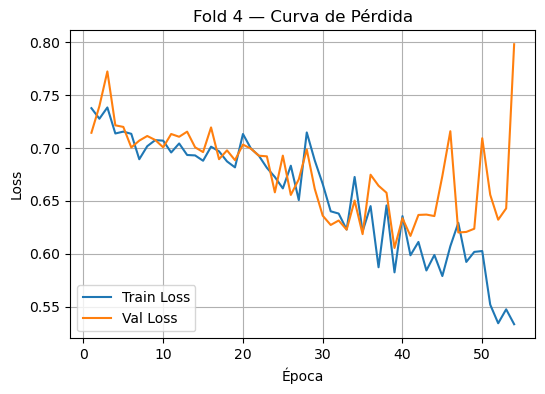

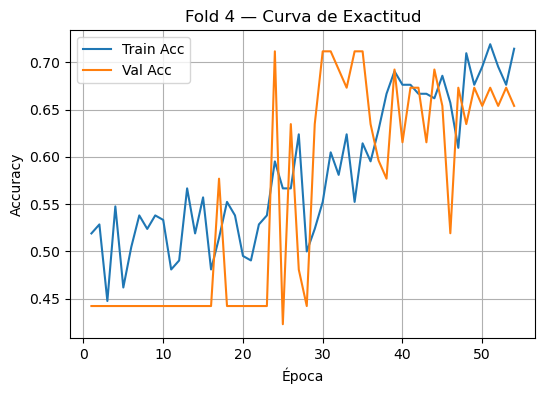


--- Fold 5 ---
Epoch 001 | Tr Loss: 0.7419 Acc: 0.4762 | Val Loss: 0.7152 Acc: 0.5000
 ↳ Mejores pesos guardados (Val Acc: 0.5000)
Epoch 002 | Tr Loss: 0.7126 Acc: 0.4714 | Val Loss: 0.6995 Acc: 0.5000
 ↳ Sin mejora 1/30
Epoch 003 | Tr Loss: 0.6947 Acc: 0.5762 | Val Loss: 0.6891 Acc: 0.5192
 ↳ Mejores pesos guardados (Val Acc: 0.5192)
Epoch 004 | Tr Loss: 0.7178 Acc: 0.5143 | Val Loss: 0.7432 Acc: 0.5000
 ↳ Sin mejora 1/30
Epoch 005 | Tr Loss: 0.7244 Acc: 0.5238 | Val Loss: 0.7164 Acc: 0.4423
 ↳ Sin mejora 2/30
Epoch 006 | Tr Loss: 0.7058 Acc: 0.5095 | Val Loss: 0.6964 Acc: 0.4808
 ↳ Sin mejora 3/30
Epoch 007 | Tr Loss: 0.6914 Acc: 0.5381 | Val Loss: 0.6941 Acc: 0.5577
 ↳ Mejores pesos guardados (Val Acc: 0.5577)
Epoch 008 | Tr Loss: 0.6789 Acc: 0.5429 | Val Loss: 0.6952 Acc: 0.5192
 ↳ Sin mejora 1/30
Epoch 009 | Tr Loss: 0.7190 Acc: 0.4905 | Val Loss: 0.6974 Acc: 0.5000
 ↳ Sin mejora 2/30
Epoch 010 | Tr Loss: 0.7084 Acc: 0.5333 | Val Loss: 0.6979 Acc: 0.5000
 ↳ Sin mejora 3/30
Epoch 

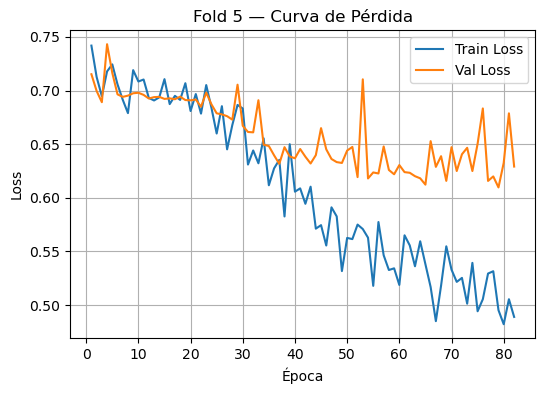

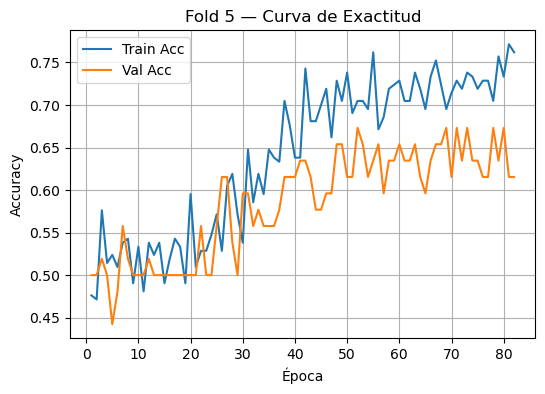

In [20]:
batch_size   = 8
patience     = 30
fold_scores  = []
num_epochs   = 500

for fold, (train_idx_fold, val_idx_fold) in enumerate(folds):
    # Listas para métricas
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []
    print(f"\n--- Fold {fold+1} ---")

    # Subsets
    train_subset = Subset(train_dataset, train_idx_fold)
    val_subset   = Subset(train_dataset, val_idx_fold)
    # Dataloaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

    # Modelo, loss, optimizador y scheduler
    model      = SoftmaxGatedFusion().to(device)
    criterion  = nn.CrossEntropyLoss()
    optimizer  = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler  = ReduceLROnPlateau(optimizer, mode='max', patience=15, factor=0.5)

    best_acc, no_improve = 0.0, 0

    for epoch in range(1, num_epochs+1):
        # --------- Entrenamiento ---------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for x_t, x_v, x_a, y in train_loader:
            x_t, x_v, x_a, y = x_t.to(device), x_v.to(device), x_a.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x_t, x_v, x_a)
            loss   = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct     += (preds == y).sum().item()
            total       += y.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc  = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # --------- Validación ---------
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x_t, x_v, x_a, y in val_loader:
                x_t, x_v, x_a, y = x_t.to(device), x_v.to(device), x_a.to(device), y.to(device)
                logits = model(x_t, x_v, x_a)
                loss   = criterion(logits, y)

                running_loss += loss.item() * y.size(0)
                preds       = logits.argmax(dim=1)
                correct     += (preds == y).sum().item()
                total       += y.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc  = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Scheduler y early stopping
        #scheduler.step(epoch_val_acc)

        print(f"Epoch {epoch:03d} | "
              f"Tr Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(),
                       f"models/gate_fusion/best_model_fold{fold+1}.pth")
            no_improve = 0
            print(f" ↳ Mejores pesos guardados (Val Acc: {best_acc:.4f})")
        else:
            no_improve += 1
            print(f" ↳ Sin mejora {no_improve}/{patience}")
            if no_improve >= patience:
                print(f" ↳ Early stopping tras {patience} épocas")
                break

    fold_scores.append(best_acc)

    # --------- Plot métricas por fold ---------
    epochs = range(1, len(train_losses)+1)

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses,   label='Val Loss')
    plt.title(f'Fold {fold+1} — Curva de Pérdida')
    plt.xlabel('Época'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    plt.show()

    # Exactitud
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs,   label='Val Acc')
    plt.title(f'Fold {fold+1} — Curva de Exactitud')
    plt.xlabel('Época'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True)
    plt.show()


In [21]:
print(f"\nAcc validación: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
best_fold = int(np.argmax(fold_scores))
print(f"Mejor fold: {best_fold+1} con precisión: {fold_scores[best_fold]:.4f}")


Acc validación: 0.6911 ± 0.0423
Mejor fold: 3 con precisión: 0.7500


In [22]:
print("Evaluacion con el mejor fold:")
print()
evaluar_modelo(model, test_loader, f"models/gate_fusion/best_model_fold{best_fold+1}.pth")

Evaluacion con el mejor fold:

Total ejemplos en test: 47
Accuracy:      0.7660
Precision:     0.8500
Recall:        0.6800
F1-score:      0.7556
Matriz de confusión:
[[19  3]
 [ 8 17]]


In [23]:
evaluar_modelo(model,test_loader, path=f"models/gate_fusion/best_model_fold1.pth")

Total ejemplos en test: 47
Accuracy:      0.5319
Precision:     0.5319
Recall:        1.0000
F1-score:      0.6944
Matriz de confusión:
[[ 0 22]
 [ 0 25]]


In [24]:
evaluar_modelo(model,test_loader, path=f"models/gate_fusion/best_model_fold2.pth")

Total ejemplos en test: 47
Accuracy:      0.7447
Precision:     0.7826
Recall:        0.7200
F1-score:      0.7500
Matriz de confusión:
[[17  5]
 [ 7 18]]


In [25]:
evaluar_modelo(model,test_loader, path=f"models/gate_fusion/best_model_fold3.pth")

Total ejemplos en test: 47
Accuracy:      0.7660
Precision:     0.8500
Recall:        0.6800
F1-score:      0.7556
Matriz de confusión:
[[19  3]
 [ 8 17]]


In [26]:
evaluar_modelo(model,test_loader, path=f"models/gate_fusion/best_model_fold4.pth")

Total ejemplos en test: 47
Accuracy:      0.7234
Precision:     0.7000
Recall:        0.8400
F1-score:      0.7636
Matriz de confusión:
[[13  9]
 [ 4 21]]


In [27]:
evaluar_modelo(model,test_loader, path=f"models/gate_fusion/best_model_fold5.pth")

Total ejemplos en test: 47
Accuracy:      0.7234
Precision:     0.8750
Recall:        0.5600
F1-score:      0.6829
Matriz de confusión:
[[20  2]
 [11 14]]
